In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
from util import getImageData, error_rate, y2indicator

In [5]:
def init_weight_and_bias(M1, M2):
    '''
    param M1,M2 : initializes weights and biases for fully connected layers.
    '''
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

def init_filter(shape, poolsz):
    '''Initializes filter weights in an attempt to avoid exploding/vanishing gradients'''
    
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


class HiddenLayer(object):
    '''
    Creates a hidden layer object.
    Hidden layers are different from convolution layers.They are added at the end of conv and pooling layers ,i.e
    after flattening the output of last conv layer.
    '''
    
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        '''
         param X: 4-D tensor [batch,image_height,image_width,channels]
        '''
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)


In [6]:
class Convolution_Pool_layer(object):
    '''
    Creates a combination of convolution layer followed by a max-pooling layer.
    '''
    def __init__(self, input_feature_maps, output_feature_maps, fw, fh, poolsz=(2,2)):
        '''
        param input_feature_maps: number of feature maps from previous operations or simply the number of channels in
                                  the current form of the image.
        param output_feature_maps: number of feature maps/filters you wish to apply in the next convolution layer.
        param fw : filter_width
        param fh: filter_height
        param poolsz: size of pooling window.
        
        Tensorflow accepts input for its conv2d utilities in a certain prescribed data format,which by default is NHWC.
        '''
        
        size = (fh,fw,input_feature_maps,output_feature_maps)
        W0 = init_filter(size, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(output_feature_maps,dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]
    
    def forward(self, X):
        '''
        param X: 4-D tensor [batch,image_height,image_width,channels]
        
        returns: the output depends upon the tanh function which returns a tensor "of same type as 'x' i.e pool_out".
        The outputs of conv2d,max_pool from tensorflow is similar to its input.The output is of the type
        [batch (usually None/?),image_height,image_width,channels].
        '''
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize=[1, p1, p2, 1],
            strides=[1, p1, p2, 1],
            padding='SAME'
        )
        return tf.tanh(pool_out)
        

In [7]:
class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
    
    def fit(self, X, Y, learning_rate=0.001, mu=0.99, reg=0.0001, decay=0.99999, epsilon=.001, batch_size=30, epochs=3, show_fig=True):
        
        # initializing the hyperparameters 
        learning_rate = np.float32(learning_rate)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        epsilon = np.float32(epsilon)
        
        K = len(set(Y))
        X,Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)
        
        # separating out a validation set
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        # training set
        X,Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1)
        
        # m : number of images or number of data or number of images in one batch
        # input_width : image width before any operation on image
        # input_height : image height before any operation on image
        m, input_width, input_height, input_channels = X.shape
        mi = input_channels
        output_width = input_width
        output_height = input_height
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = Convolution_Pool_layer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            output_width = output_width//2
            output_height = output_height//2
            mi = mo
            
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*output_width*output_height
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1,M2,count)
            self.hidden_layers.append(h)
            M1 = M2
            count+=1
            
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W,'W_logreg')
        self.b = tf.Variable(b,'b_logreg')
        
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params+= h.params
            
        
        tfX = tf.placeholder(tf.float32, shape=(None,input_height,input_width,input_channels), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        activations = self.forward(tfX)
        
        regularized_cost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=activations,labels=tfY)) + regularized_cost
        
        prediction = self.predict(tfX)
        
        train = tf.train.RMSPropOptimizer(learning_rate,decay=decay, momentum=mu).minimize(cost)
        
        n_batches = m//batch_size
        
        costs = []
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            for i in range(epochs):
                X,Y = shuffle(X,Y)
                for j in range(n_batches):
                    X_batch = X[j*batch_size:(j*batch_size+batch_size)]
                    Y_batch = Y[j*batch_size:(j*batch_size+batch_size)]
                    
                    sess.run(train, feed_dict={tfX:X_batch,tfY:Y_batch})
                    
                    if j%20 == 0:
                        c = sess.run(cost, feed_dict={tfX:Xvalid,tfY:Yvalid})
                        costs.append(c)
                        
                        p = sess.run(prediction,feed_dict={tfX:Xvalid,tfY:Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        
                        print("i:",i,"j:",j,"nb:",n_batches,"cost:",c,"error_rate:",e)
            
        if show_fig==True:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])

        for h in self.hidden_layers:
            Z = h.forward(Z)
        print(Z.shape,self.W.shape)
        return tf.matmul(Z, self.W) + self.b
        
    def predict(self, X):
        predictions = self.forward(X)
        return tf.argmax(predictions,1)        

hi
(?, 300) (300, 7)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

(?, 300) (300, 7)
i: 0 j: 0 nb: 1308 cost: 1.9940625 error_rate: 0.881
i: 0 j: 20 nb: 1308 cost: 1.9918905 error_rate: 0.777
i: 0 j: 40 nb: 1308 cost: 1.9720836 error_rate: 0.825
i: 0 j: 60 nb: 1308 cost: 1.9773155 error_rate: 0.777
i: 0 j: 80 nb: 1308 cost: 1.9767992 error_rate: 0.772
i: 0 j: 100 nb: 1308 cost: 1.950118 error_rate: 0.777
i: 0 j: 120 nb: 1308 cost: 1.9740256 error_rate: 0.778
i: 0 j: 140 nb: 1308 cost: 1.9600798 error_rate: 0.76
i: 0 j: 160 nb: 1308 cost: 1.9471431 error_rate: 0.768
i: 0 j: 180 nb: 1308 cost: 1.9669235 error_rate: 0.816
i: 0 j: 200 nb: 1308 cost: 1.9351221 error_rate: 0.762
i: 0 j: 220 nb: 1308 cost: 1.9220856 error_rate: 0.777
i: 0 j: 240 nb: 1308 cost: 1.9109603 error_rate: 0.748
i: 0 j: 260 nb: 1308 cost: 1.9334534 error_rate: 0.775
i: 0 j:

i: 2 j: 200 nb: 1308 cost: 1.2822582 error_rate: 0.471
i: 2 j: 220 nb: 1308 cost: 1.28588 error_rate: 0.471
i: 2 j: 240 nb: 1308 cost: 1.2847308 error_rate: 0.495
i: 2 j: 260 nb: 1308 cost: 1.3258466 error_rate: 0.484
i: 2 j: 280 nb: 1308 cost: 1.2784274 error_rate: 0.478
i: 2 j: 300 nb: 1308 cost: 1.2964528 error_rate: 0.47
i: 2 j: 320 nb: 1308 cost: 1.2657082 error_rate: 0.473
i: 2 j: 340 nb: 1308 cost: 1.257635 error_rate: 0.47
i: 2 j: 360 nb: 1308 cost: 1.2591983 error_rate: 0.476
i: 2 j: 380 nb: 1308 cost: 1.2721157 error_rate: 0.481
i: 2 j: 400 nb: 1308 cost: 1.295528 error_rate: 0.473
i: 2 j: 420 nb: 1308 cost: 1.2939457 error_rate: 0.462
i: 2 j: 440 nb: 1308 cost: 1.283929 error_rate: 0.466
i: 2 j: 460 nb: 1308 cost: 1.2675396 error_rate: 0.462
i: 2 j: 480 nb: 1308 cost: 1.2737298 error_rate: 0.477
i: 2 j: 500 nb: 1308 cost: 1.2886562 error_rate: 0.483
i: 2 j: 520 nb: 1308 cost: 1.2712365 error_rate: 0.466
i: 2 j: 540 nb: 1308 cost: 1.2972195 error_rate: 0.472
i: 2 j: 560 nb: 1

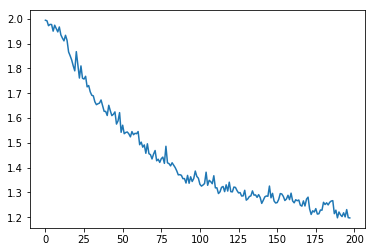

In [8]:
def main():
    
    X,Y = getImageData()
    X = X.transpose((0,2,3,1))
    model = CNN(convpool_layer_sizes=[(20,5,5),(20,5,5)], hidden_layer_sizes=[500,300],)
    model.fit(X,Y,show_fig=True)

if __name__ == '__main__':
    
    main()
    